In [83]:
import numpy as np
import scipy as scp
import re
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import matplotlib.pyplot as plt

#from HIV_project.scripts.download import read_fasta

In [59]:
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [39]:
### Should be imported but I dunno how 	(⇀‸↼‶)

def sort_lst(lst):
    """
    Making list, which contain numbers in str format, sorted, but numbers will still be in str

    Args:
        lst: list, list to sort

    Returns:
        list

    """
    return [str(x) for x in sorted([int(x) for x in lst])]


def read_fasta(path):
    """
    Read fasta
    Args:
        path: str, path to fasta file

    Returns:
        list of dicts and list of day:
            dict in list of dicts have 'desc' and 'seq' keys
            list of days contain all days of HIV seq we know for exact patient
    """
    haplo_seq_dict = []
    days = []
    patt = r'_[\d]*_'  # for days
    records = []
    with open(path) as fasta_file:  # Reading
        for record in SeqIO.parse(fasta_file, 'fasta'):
            records.append(record)

    haplo_seq_dict = []
    for record in records:
        haplo_seq_dict.append({})
        if 'reference' in record.description:
            haplo_seq_dict[-1]['seq'] = str(record.seq)
            haplo_seq_dict[-1]['desc'] = 'reference'
            days.append('0')
        # print('1')
        if 'reference' not in record.description:  # Making days, lst
            days.append((re.search(patt, record.description).group(0).replace('_', '')))
            haplo_seq_dict[-1]['seq'] = str(record.seq)
            haplo_seq_dict[-1]['desc'] = record.description.lstrip()

    days = list(set(days))
    days = sort_lst(days)

    return haplo_seq_dict, days


def preparing_data(haplo_seq_dict, days):
    patt = r'_[\d]*_'
    seq_dict = {} 
    seq_name_days_dict = {x:[] for x in days}
    for obj in haplo_seq_dict:
        seq_dict[obj['desc']]=obj['seq']
        res = re.search(patt, obj['desc'])
        if res != None:
            seq_name_days_dict[re.search(patt, obj['desc']).group(0).replace('_','')].append(obj['desc'])
        else:
            pass
    return seq_dict, seq_name_days_dict

def translating_seqs(seq_dict):
    prot_dict = {}
    for key in seq_dict:
        prot_dict[key] = translate_dna(seq_dict[key])
    return prot_dict

def translate_dna(sequence):
    """
    :param sequence: (str) a DNA sequence string
    :return: (str) a protein string from the forward reading frame 1
    """
    codontable = {'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
              'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
              'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
              'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
              'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
              'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
              'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
              'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
              'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
              'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
              'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
              'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
              'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
              'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
              'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
              'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W',
              '---': '-',
              }

    seq = sequence.upper()
    prot = []
    
    n = 0
    while n+3 < len(seq):
        if seq[n:n + 3] in codontable:
            residue = codontable[seq[n:n + 3]]
        else:
            residue = "X"
        prot.append(residue)
        n += 3
    return "".join(prot)

In [40]:
haplo_seq_dict, days = read_fasta('data/fasta/hivevo_p1_V3.fasta')
seq_dict, seq_name_days_dict = preparing_data(haplo_seq_dict, days)
prot_dict = translating_seqs(seq_dict)

In [41]:
a = 'ATGTCT-TGC'
translate_dna(a)

'MSX'

In [63]:
seq_name_days_dict['122']

['days_122_frequency_100%']

In [56]:
# prepating data

def finding_frequency(string):
    '''
    This function finds frequencies of amino acids. Thus there only amino acid alphabet ('A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'X' ) is used. 
    Function return frequency of each amino acid by list: Alanin is first, Argenin - second and so on (see alphabet).
    Parametrs:
        string - what should be analyzed
    '''
    Alphabet = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
    result = []
    for x in Alphabet:
            result.append(string.count(x)/len(string))
    return result

def calculating_clf_metric(prot_dict, seq_name_dict, days):
    days_objects = {day:[] for day in days}
    for day in days:
        if day == '0':
            days_objects[day].append(finding_frequency(prot_dict['reference']))
        lst_prot_name = seq_name_dict[day]
        for prot_name in lst_prot_name:
            res = finding_frequency(prot_dict[prot_name])
            days_objects[day].append(res)
    return days_objects

In [57]:
days_objects = calculating_clf_metric(prot_dict, seq_name_days_dict, days)

In [101]:
sample = days_objects['0']
sample

[[0.0423728813559322,
  0.05084745762711865,
  0.0847457627118644,
  0.03389830508474576,
  0.01694915254237288,
  0.025423728813559324,
  0.07627118644067797,
  0.06779661016949153,
  0.03389830508474576,
  0.1271186440677966,
  0.06779661016949153,
  0.06779661016949153,
  0.00847457627118644,
  0.03389830508474576,
  0.03389830508474576,
  0.05084745762711865,
  0.0847457627118644,
  0.00847457627118644,
  0.00847457627118644,
  0.07627118644067797]]

In [60]:
# Our classificator

Gradboost = load('saved_sklearn_models/Gradboost.joblib')

In [92]:
Gradboost.predict_proba(sample)

array([[0.50010876, 0.49989124]])

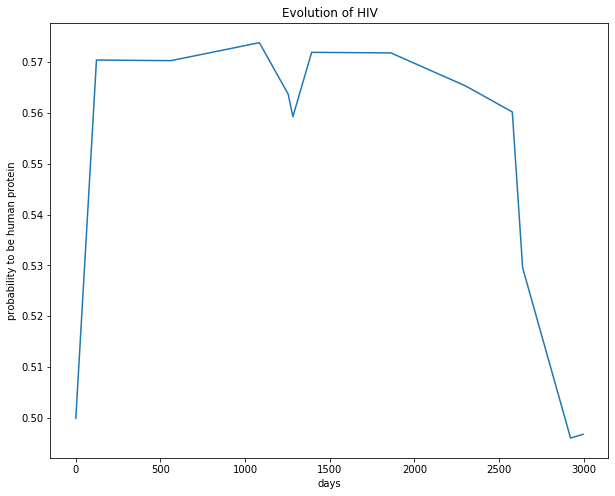

In [111]:
X = list(map(int, list(days_objects.keys())))
Y = []
for day in days:
    obj_lst = days_objects[day]
    res = 0
    for pred in Gradboost.predict_proba(obj_lst):
        res += pred[1]
    Y.append(res/len(obj_lst))

fig = plt.figure(figsize=(10,8))
plt.xlabel('days')
plt.title('Evolution of HIV')
plt.ylabel('probability to be human protein')
plt.plot(X, Y, label='Gradboost')
plt.show()